## Problem Statement

We are interested in developing a robust machine learning system that leverages information coming from call center data.

Ultimately, we are looking for ways to improve the success rate for calls made to customers for any product that our clients offer. Towards this goal we are working on designing an ever evolving machine learning product that offers high success outcomes while offering interpretability for our clients to make informed decisions.

### Data Description:

The data comes from direct marketing efforts of a European banking institution. The marketing campaign involves making a phone call to a customer, often multiple times to ensure a product subscription, in this case a term deposit. Term deposits are usually short-term deposits with maturities ranging from one month to a few years. The customer must understand when buying a term deposit that they can withdraw their funds only after the term ends. All customer information that might reveal personal information is removed due to privacy concerns.

### Attributes:

age : age of customer (numeric)

job : type of job (categorical)

marital : marital status (categorical)

education (categorical)

default: has credit in default? (binary)

balance: average yearly balance, in euros (numeric)

housing: has a housing loan? (binary)

loan: has personal loan? (binary)

contact: contact communication type (categorical)

day: last contact day of the month (numeric)

month: last contact month of year (categorical)

duration: last contact duration, in seconds (numeric)

campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

Output (desired target):

y - has the client subscribed to a term deposit? (binary)



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
%matplotlib inline

from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV

# imblearn
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# basic models
import lazypredict
from lazypredict.Supervised import LazyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import classification_report



### Data Loading, Exploration and Transformation 

The Dataset has some categorical variables which requires transformation (i.e changing them to numerical representations).
Firstly, the binary variables will be transform using the Label encoder. 


In [2]:
# Read in Dataset
Data = pd.read_csv('C:\\Users\\Public\\term-deposit-marketing-2020.csv')
Dataset = Data.copy()

In [3]:
print(Dataset.shape)
Dataset.head()

(40000, 14)


age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign   y  
0  unknown    5   may       261         1  no  
1  unknown    5   may       151         1  no  
2  unknown    5   may        76         1  no  
3  unknown    5   may        92         1  no  
4  unknown    5   may       198         1  no

In [4]:
Dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [5]:
# see if there are duplicates rows in the data
sum(Dataset.duplicated())

0

In [6]:
Dataset.describe()

age   balance      day  duration  campaign
count 40000.00  40000.00 40000.00  40000.00  40000.00
mean     40.54   1274.28    16.02    254.82      2.88
std       9.64   2903.77     8.28    259.37      3.24
min      19.00  -8019.00     1.00      0.00      1.00
25%      33.00     54.00     8.00    100.00      1.00
50%      39.00    407.00    17.00    175.00      2.00
75%      48.00   1319.00    21.00    313.00      3.00
max      95.00 102127.00    31.00   4918.00     63.00

Dataset has:
* no missing, null value and no duplicated row
* contains 40000 entries(rows) and a total of 14 columns
* 8 catagoral and 5 numeric features
* 13 features and the targt (y)
* its categorical features are both ordinal and norminal
* the numerical feature, 'balance' has some negative values
* the numerical feature, 'duration' has some zeros

In [7]:
# checking if the customers with negative balances subscribed to term deposit
print('balance:')
print(Dataset[Dataset['balance']<=0]['y'].value_counts())

balance:
no     6564
yes     376
Name: y, dtype: int64


In [8]:
# checking if the customers with zero duration subscribed to term deposit
print('duration:')
print(Dataset[Dataset['duration']==0]['y'].value_counts())

duration:
no    3
Name: y, dtype: int64


no    0.93
yes   0.07
Name: y, dtype: float64


<AxesSubplot:>

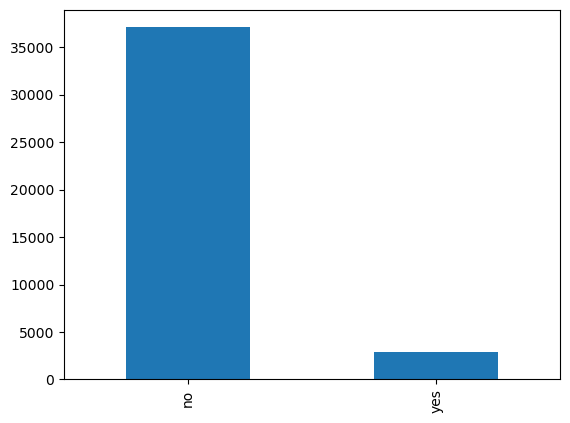

In [9]:
print(Dataset['y'].value_counts(normalize=True))
Dataset['y'].value_counts().plot.bar()

* The Dataset has an imbalance distribution of the target 'y', with 92% not subscribed and 7% subscribed

In [10]:
# define categorical and numerical features

categorical_col = []
numerical_col = []
for col in Dataset.columns:
  if Dataset[col].dtype == 'object':
    categorical_col.append(col)
  elif Dataset[col].dtype == 'int64':
    numerical_col.append(col)
print(f'Categorical columns: {categorical_col}')
print(f'Numerical columns: {numerical_col}')

Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'y']
Numerical columns: ['age', 'balance', 'day', 'duration', 'campaign']


In [11]:
# Check for unique labels in each CATEOGRICAL column
for col in Dataset.columns:
    if(Dataset[col].dtype.name != 'object'): continue
    print(f'{col}: {len(Dataset[col].unique())} unique values\n')
    print(f'{Dataset[col].unique()}\n')
    print('----------------------------------------------------------------------\n')

job: 12 unique values

['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']

----------------------------------------------------------------------

marital: 3 unique values

['married' 'single' 'divorced']

----------------------------------------------------------------------

education: 4 unique values

['tertiary' 'secondary' 'unknown' 'primary']

----------------------------------------------------------------------

default: 2 unique values

['no' 'yes']

----------------------------------------------------------------------

housing: 2 unique values

['yes' 'no']

----------------------------------------------------------------------

loan: 2 unique values

['no' 'yes']

----------------------------------------------------------------------

contact: 3 unique values

['unknown' 'cellular' 'telephone']

----------------------------------------------------------------------

month: 11 u

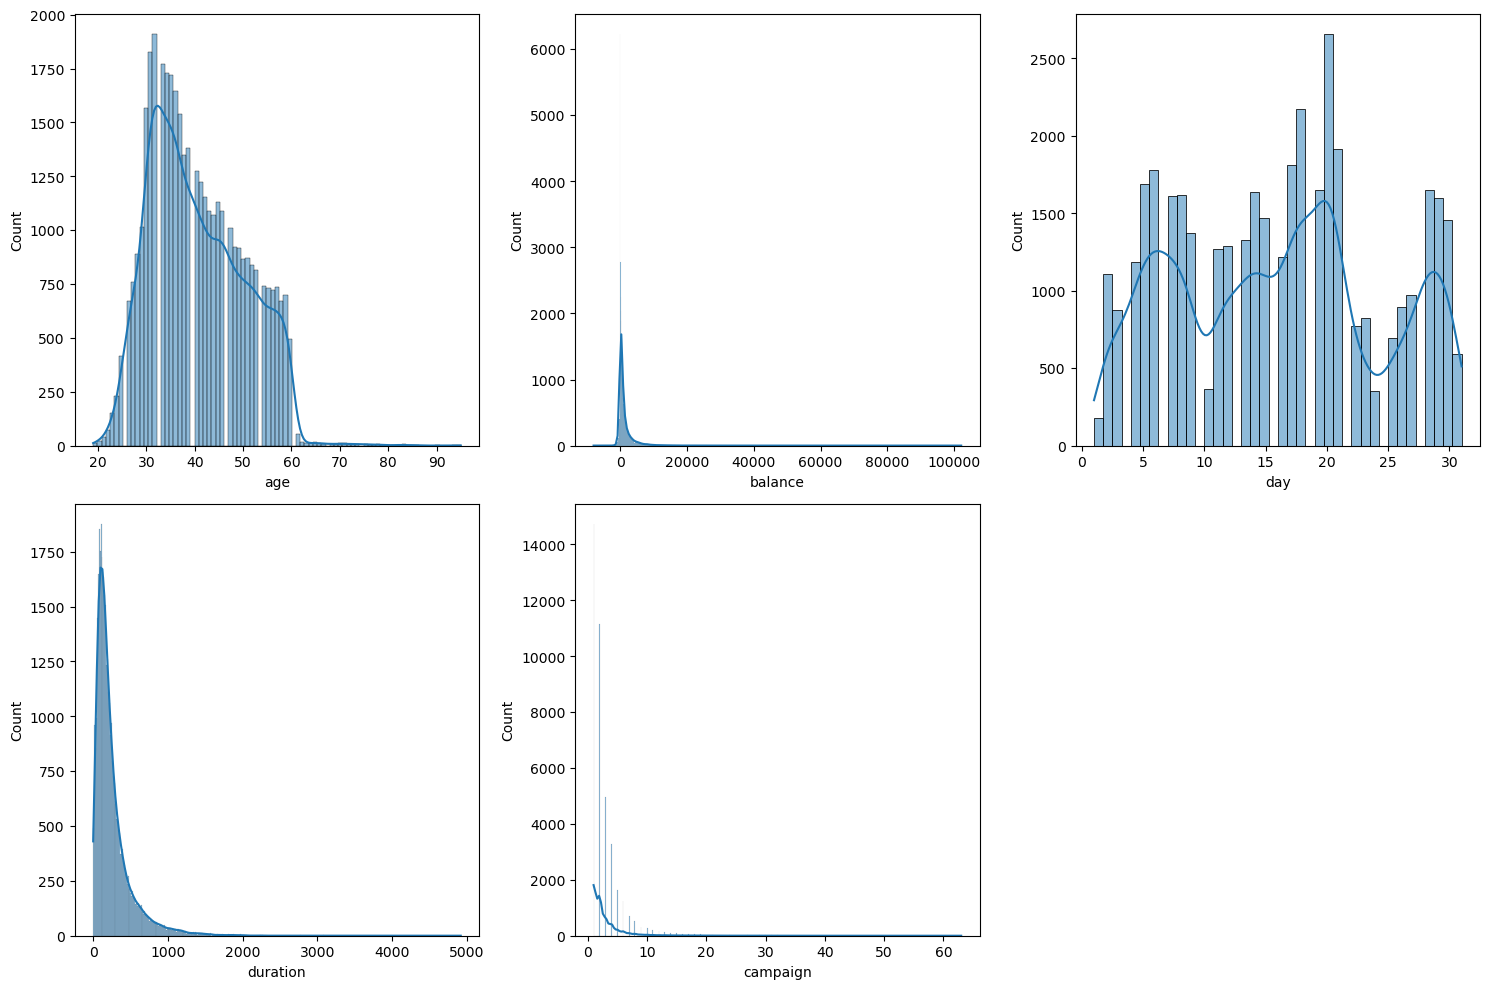

In [12]:
# distributions of numerical data

plt.figure(figsize=(15,10))
i = 1 
for col in numerical_col:
  ax = plt.subplot(2,3,i)
  sns.histplot(data=Dataset, x=col, kde=True)
  i+=1
plt.tight_layout()
plt.show()

Observation: from the above histograms we can see that:

* Most of the customers are aged between 30 and 50.
* Majority of the customers have a 'balance' below 10k
* Most calls 'duration' are usually between 0 to 500 secs.
* Between 0 and 10 contacts were made to customers during this campaigns.

Most of our numerical features have a right skewed and show the presence of outliers.

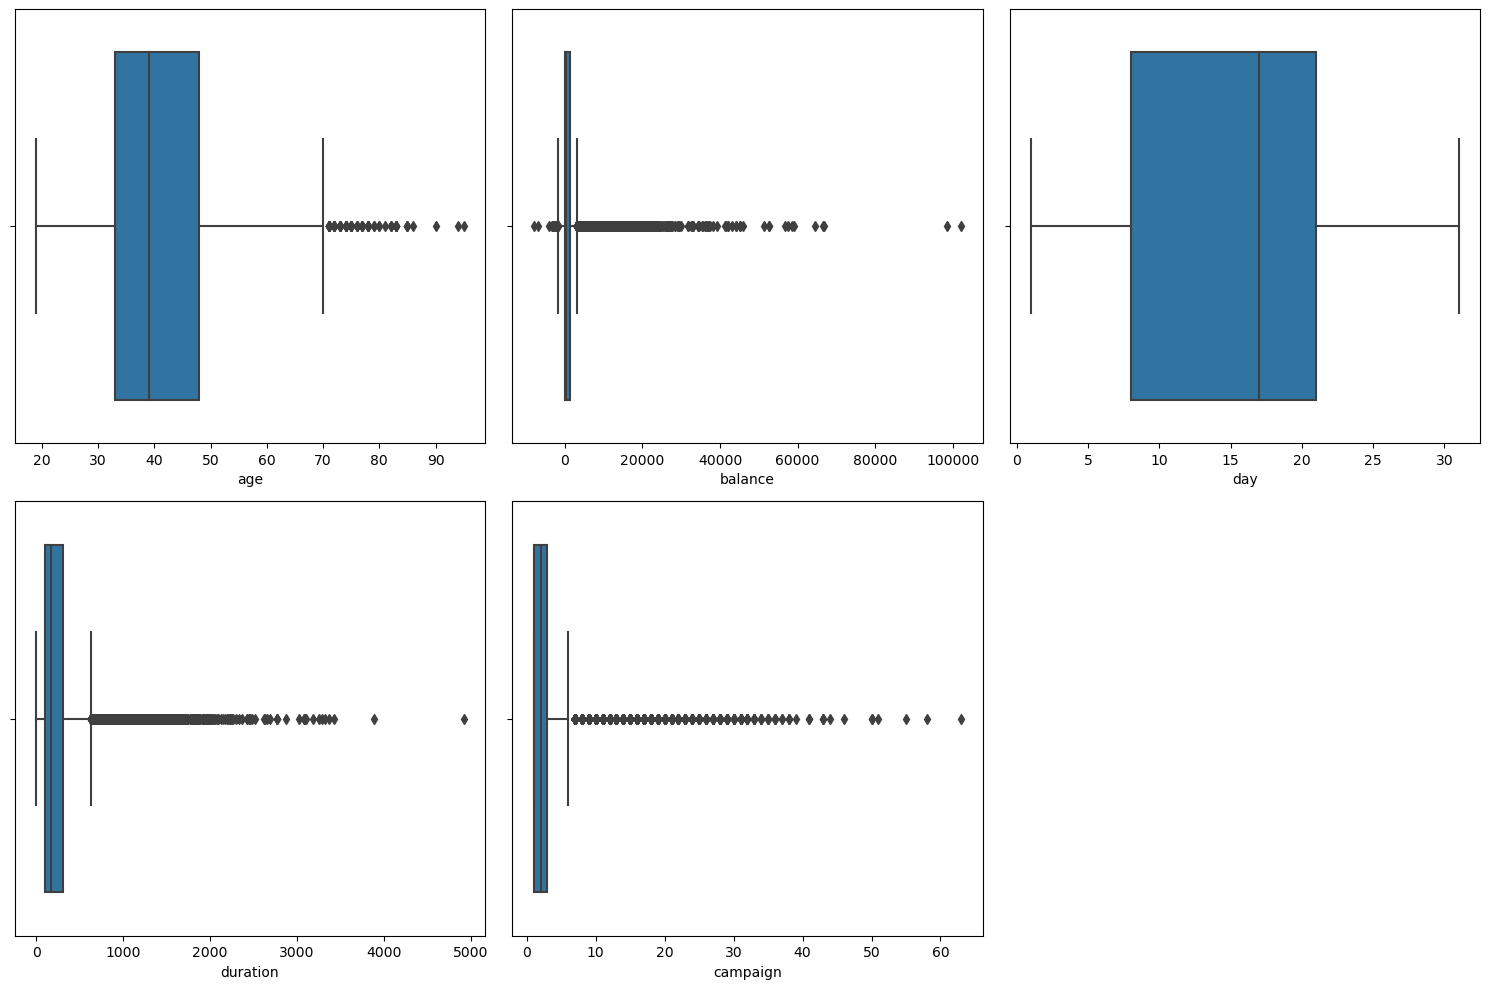

In [13]:
# using the boxplot to examine the outliers
plt.figure(figsize=(15,10))
i = 1 
for col in numerical_col:
  ax = plt.subplot(2,3,i)
  sns.boxplot(data=Dataset, x=col)
  i+=1
plt.tight_layout()
plt.show()

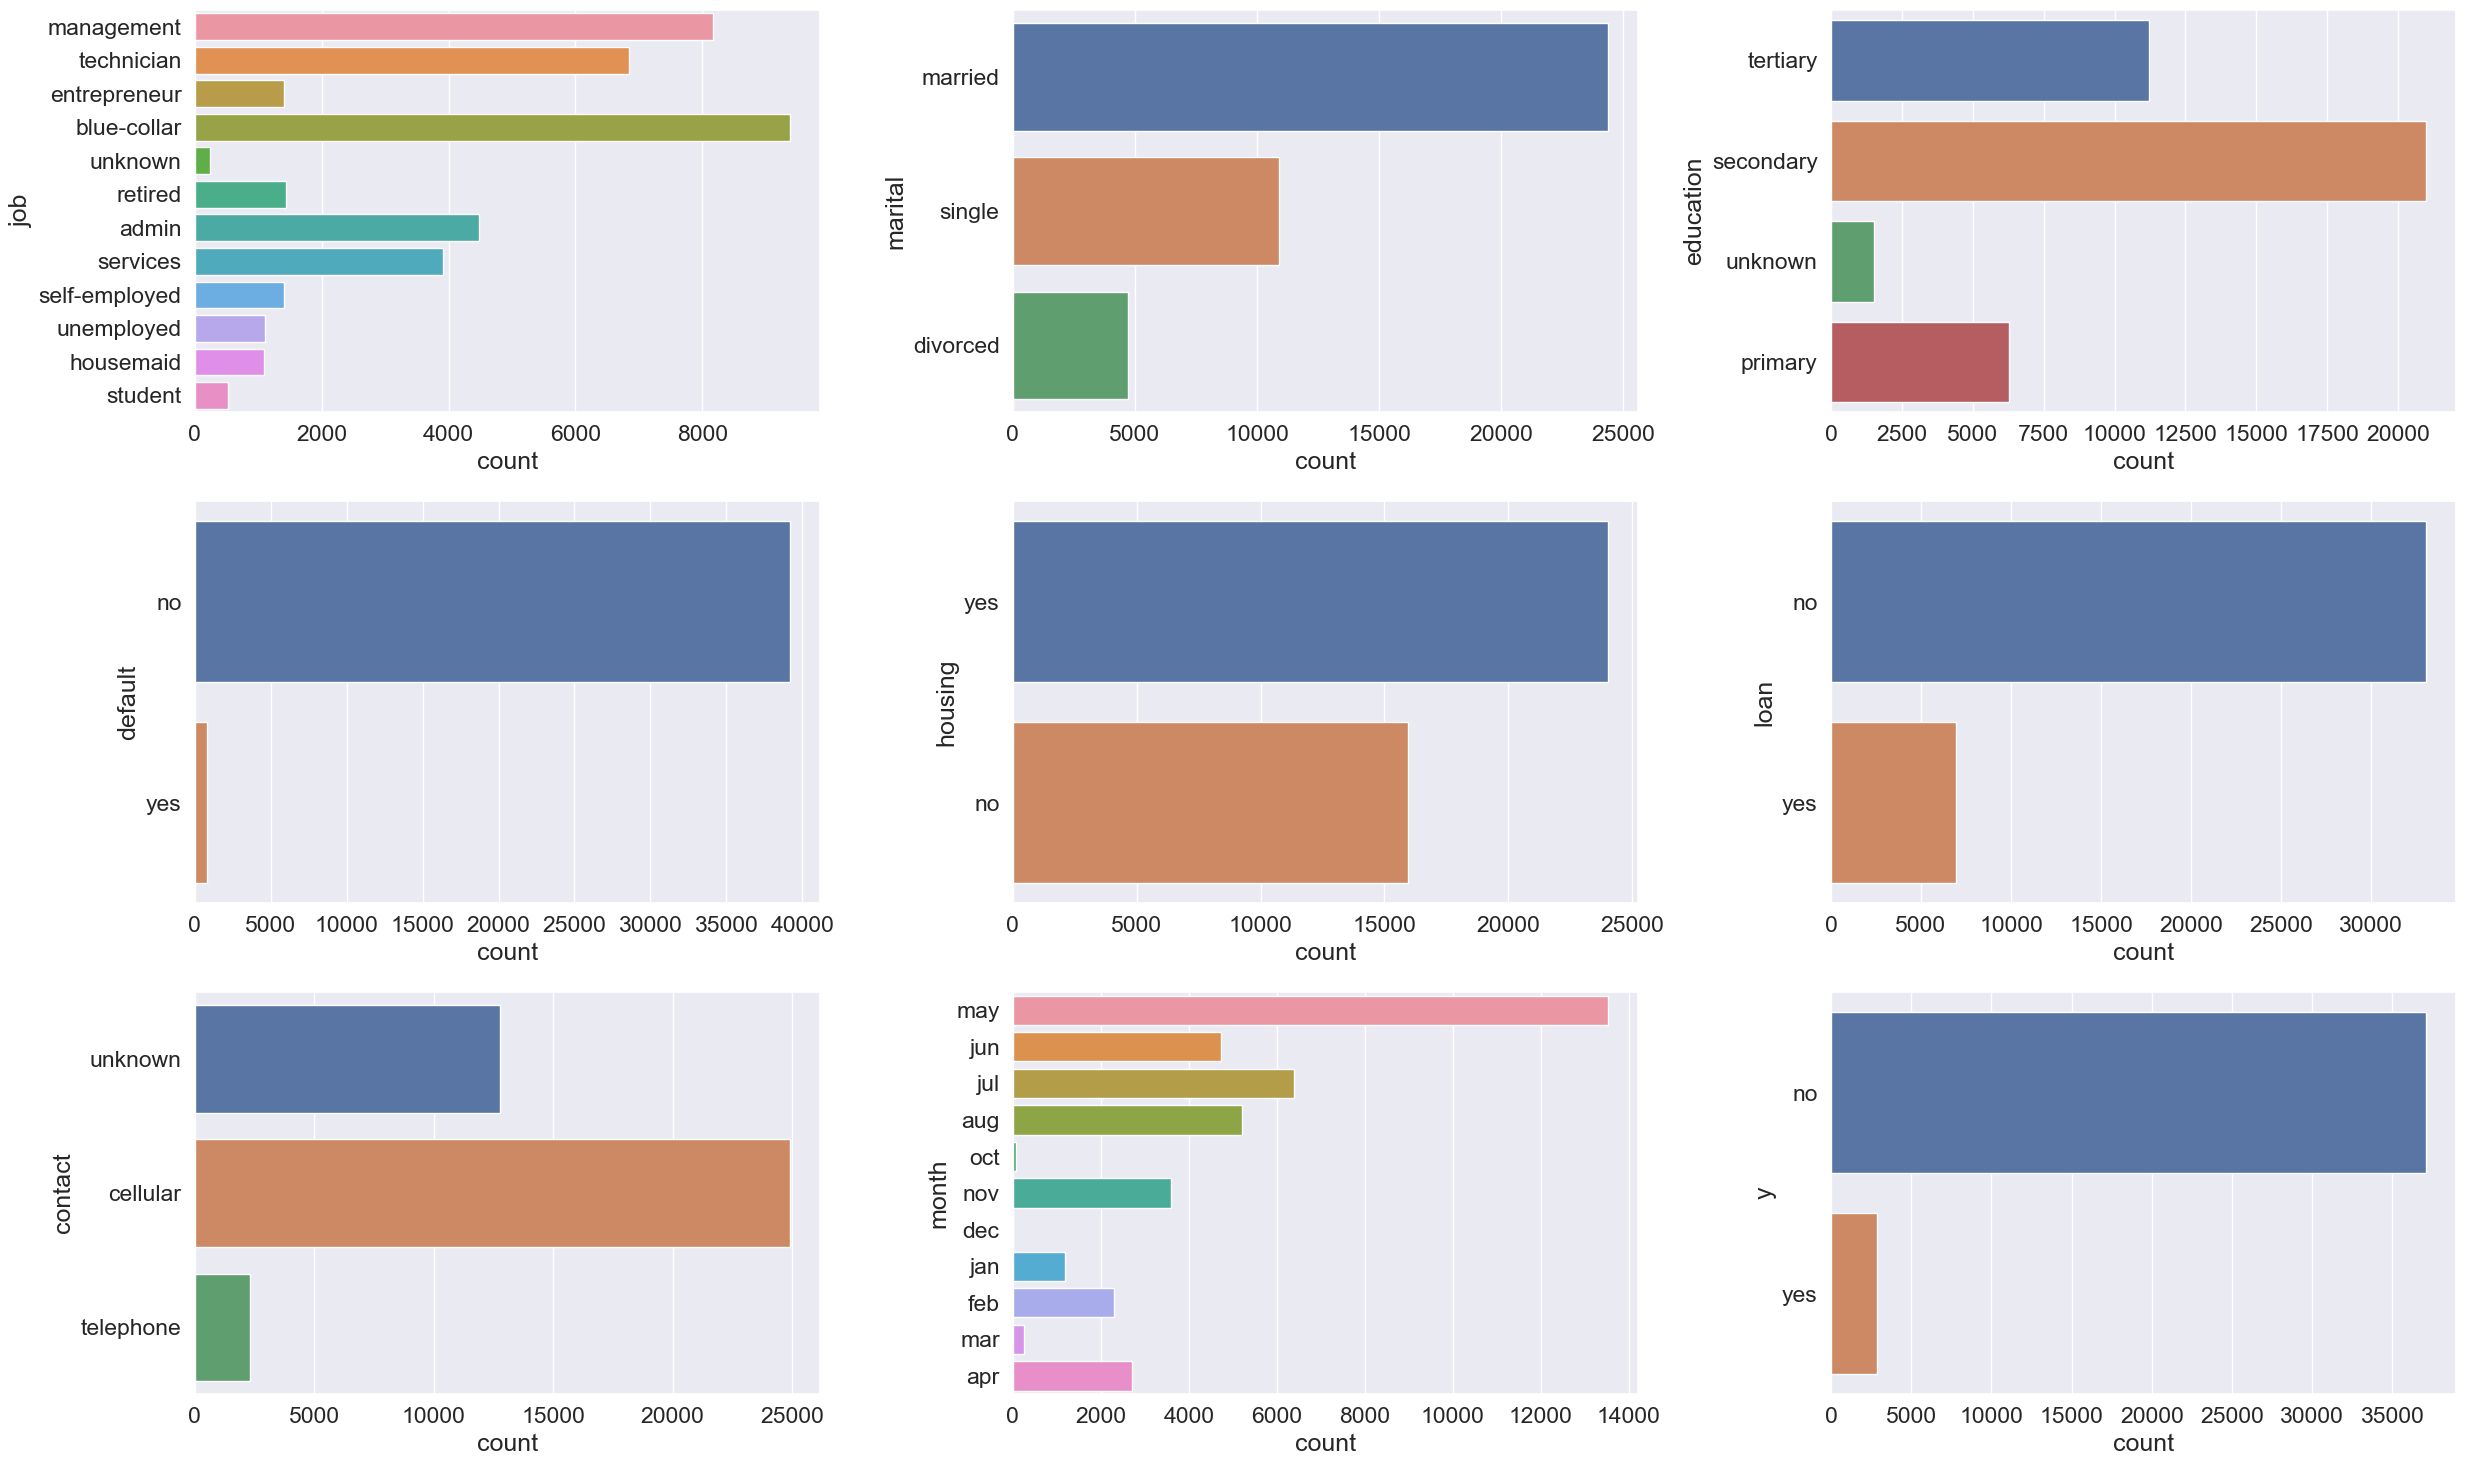

In [14]:
# countplots of categorical features
sns.set(font_scale = 1.5)
plt.figure(figsize=(25,15))
i=1
for col in categorical_col:
    ax = plt.subplot(3,3,i)
    sns.countplot(y=col,data=Dataset)
    i += 1
plt.tight_layout()
plt.show()

In [15]:
# let's examine the binary categorical columns
Bi_cols = ['loan','default','housing']
nrows = 40000
for i,col in enumerate(Bi_cols):
  v1 = Dataset[Dataset[col]=='yes'].shape[0]
  v2 = Dataset[Dataset[col]=='yes']['y'].value_counts()[0]
  if i==0:
    print(f'{v1}/{nrows} have a personal loan.')
    print(f'{v2}/{v1} have not subscribed to a term deposit.')
    print('---------------------------------------------------')
  elif i==1:
    print(f'{v1}/{nrows} have defaulted before.')
    print(f'{v2}/{v1} have not subscribed to a term deposit.')
    print('---------------------------------------------------')
  else:
    print(f'{v1}/{nrows} have a housing loan.')
    print(f'{v2}/{v1} have not subscribed to a term deposit.')
    print('---------------------------------------------------')

6930/40000 have a personal loan.
6550/6930 have not subscribed to a term deposit.
---------------------------------------------------
809/40000 have defaulted before.
760/809 have not subscribed to a term deposit.
---------------------------------------------------
24031/40000 have a housing loan.
22567/24031 have not subscribed to a term deposit.
---------------------------------------------------


* The above shows that majority of those who have a personal loan or defaulted before or have a housing loan have not subscribed to a term deposit

In [16]:
# creating a dictionary to represent the contents of the binary categorical columns in a numeric order

binary_dict = {'no':0, 'yes':1}

# This maps the original values of binary columns to the corrresponing values in the dictionary
# Afterward yes=1 and no=0

Dataset['default'] = Dataset.default.map(binary_dict)
Dataset['housing'] = Dataset.housing.map(binary_dict)
Dataset['loan'] = Dataset.loan.map(binary_dict)
Dataset['y'] = Dataset.y.map(binary_dict)

In [17]:
Dataset.head()

age           job  marital  education  default  balance  housing  loan  \
0   58    management  married   tertiary        0     2143        1     0   
1   44    technician   single  secondary        0       29        1     0   
2   33  entrepreneur  married  secondary        0        2        1     1   
3   47   blue-collar  married    unknown        0     1506        1     0   
4   33       unknown   single    unknown        0        1        0     0   

   contact  day month  duration  campaign  y  
0  unknown    5   may       261         1  0  
1  unknown    5   may       151         1  0  
2  unknown    5   may        76         1  0  
3  unknown    5   may        92         1  0  
4  unknown    5   may       198         1  0

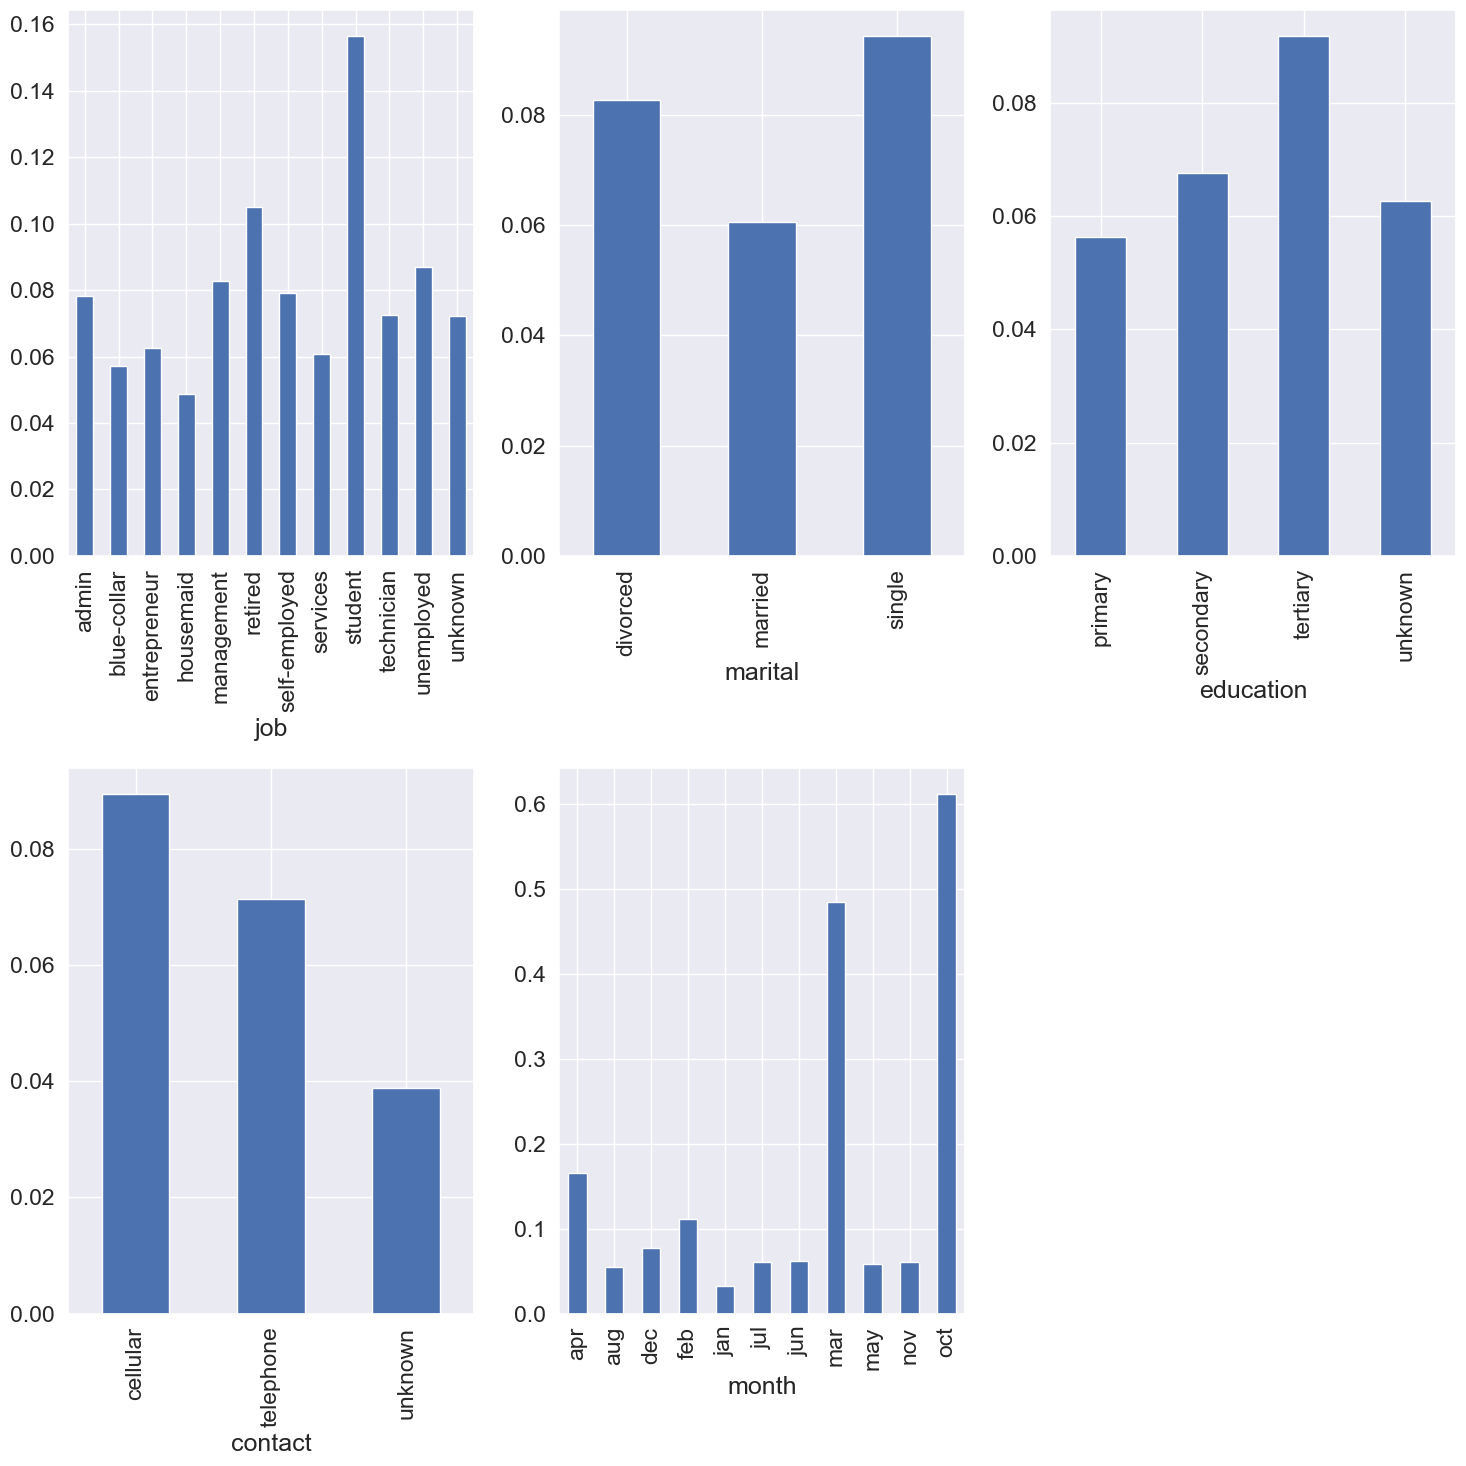

In [18]:
# checking the probability of subscribing to a term deposit using the nominal categorical columns
# barplots of other categorical features based on the corresponding mean value of the target variable

other_cat_cols = ['job', 'marital', 'education', 'contact', 'month']
plt.figure(figsize=(15,15))
i = 1 
for col in other_cat_cols:
  ax = plt.subplot(2,3,i)
  Dataset.groupby([col])['y'].mean().plot.bar()
  i+=1
plt.tight_layout()
plt.show()

* The above shows that a unmarried ('single') 'student' in a 'tertiary' institute and uses a cellular 'contact' line has a higher chance of subscribing to a term deposit in the 'month' of may and oct

In [19]:
# creating a dictionary to represent the contents of the categorical columns in a numeric order

month_dict = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9,'oct': 10, 
              'nov': 11, 'dec': 12}
job_dict = {'management': 12, 'technician':11, 'entrepreneur':10, 'blue-collar':9, 'unknown':8, 'retired':7, 
            'admin':6, 'services':5, 'self-employed':4, 'unemployed':3, 'housemaid':2, 'student':1}
marital_dict = {'married':2, 'single':1, 'divorced':0}
education_dict = {'tertiary':3, 'secondary':2, 'primary':1,'unknown':0}
contact_dict = {'unknown':0, 'cellular':1, 'telephone':2}

# replacing the original values in those columns with their corresponding numeric representation on the dictionary

Dataset['month'] = Dataset.month.map(month_dict)
Dataset['job'] = Dataset.job.map(job_dict)
Dataset['marital'] = Dataset.marital.map(marital_dict)
Dataset['education'] = Dataset.education.map(education_dict)
Dataset['contact'] = Dataset.contact.map(contact_dict)
Dataset.head()

age  job  marital  education  default  balance  housing  loan  contact  \
0   58   12        2          3        0     2143        1     0        0   
1   44   11        1          2        0       29        1     0        0   
2   33   10        2          2        0        2        1     1        0   
3   47    9        2          0        0     1506        1     0        0   
4   33    8        1          0        0        1        0     0        0   

   day  month  duration  campaign  y  
0    5      5       261         1  0  
1    5      5       151         1  0  
2    5      5        76         1  0  
3    5      5        92         1  0  
4    5      5       198         1  0

### Correlation of features to target using the Pearson's correlation

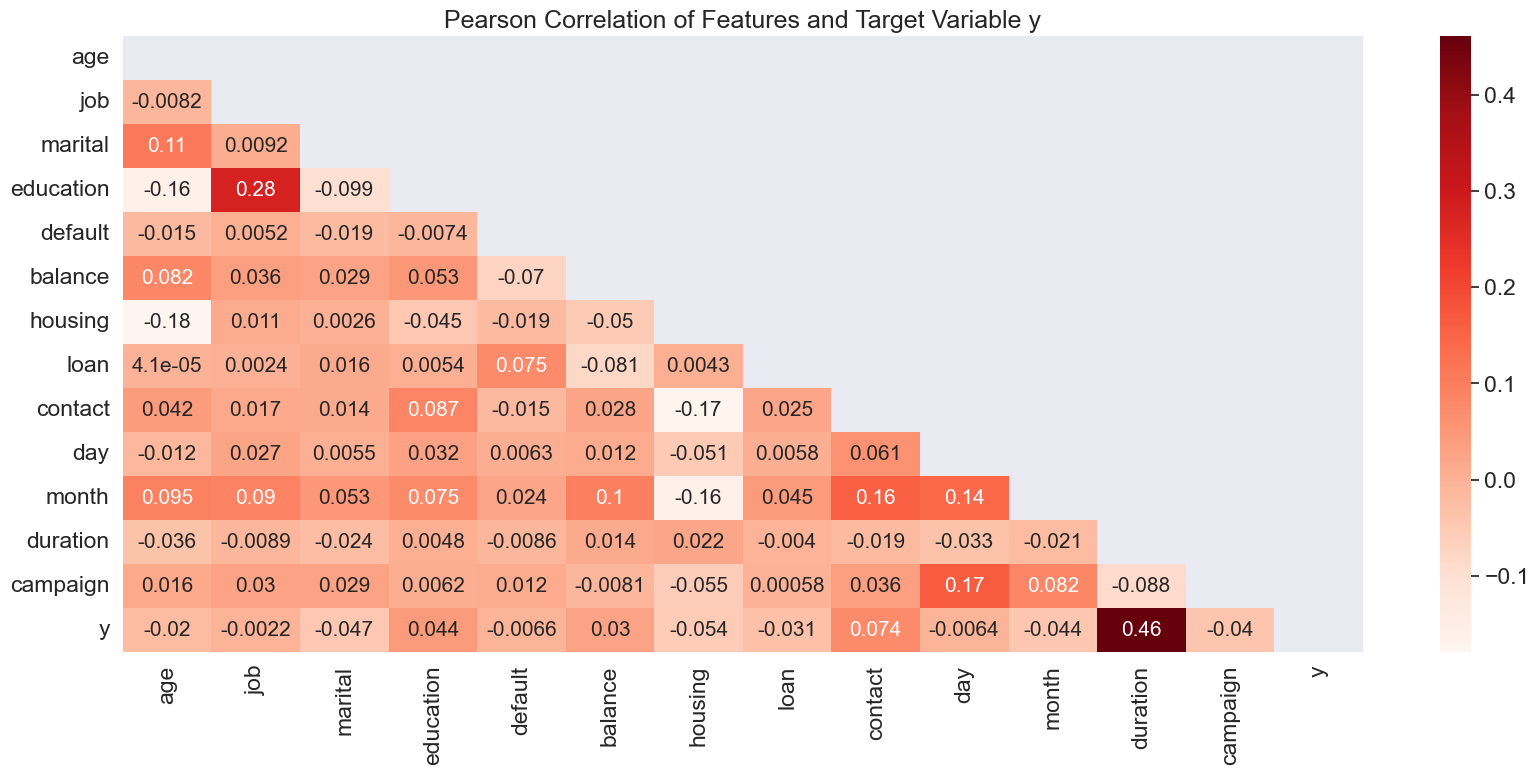

In [20]:
# Correlation Heatmap

sns.set(font_scale=1.5)

# correlation 
cor = Dataset.corr('pearson')
matrix = np.triu(cor)

# heatmap to visualise the correlation
plt.figure(figsize=(20,8))
plt.title('Pearson Correlation of Features and Target Variable y')
sns.heatmap(cor,annot=True, cmap=plt.cm.Reds, mask=matrix,annot_kws={'size': 15})
plt.show()

Observation:from the above heatmap, we see that:
* 'duration', 'contact', 'education', and 'balance' have the strongest correlation respectively to the target 'y'

### Data Preprocessing
* Spliting the Dataset into training and test set
* Balancing the dataset

0   0.93
1   0.07
Name: y, dtype: float64


<AxesSubplot:>

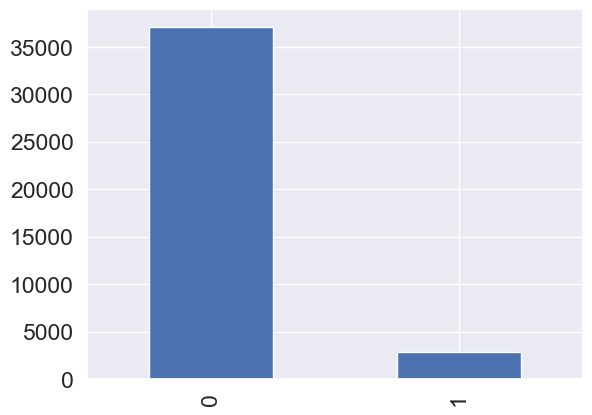

In [21]:
print(Dataset['y'].value_counts(normalize=True))
Dataset['y'].value_counts().plot.bar()

* From the above chart , we can see that the dataset is not balanced. The negative class "no" is 93%, wwhile the positive class is 7%
* An oversampling technique, SMOTE (Synthetic Minority Oversampling TEchnique) to oversample the minority class (yes = 1)
* Also, an undersampling technique, RandomUnderSample to reduce the majority class (no = 0)

### Splitting the Dataset into training and test set

In [22]:
# Splitting the Dataset into training and test set

np.random.seed(0)
X=Dataset.drop('y', axis=1) # defining the features of our dataset
Y=Dataset['y'] # defining the target Y
X_train,X_test,Y_train,Y_test=train_test_split(X,Y, test_size=0.2)

In [23]:
# Let's see the number of samples in each class for our train set.

unique, count =np.unique(Y_train, return_counts=True)
Y_train_dict={ k:v for (k,v) in zip(unique, count)}
Y_train_dict

{0: 29679, 1: 2321}

### Balancing the Dataset Using the Oversampling Technique, SMOTE 

In [24]:
print("Before OverSampling, counts of label '1': {}".format(sum(Y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(Y_train == 0)))

sm = SMOTE(random_state=0, sampling_strategy = 1.0)
x_train_res, y_train_res = sm.fit_resample(X_train, Y_train)

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

Before OverSampling, counts of label '1': 2321
Before OverSampling, counts of label '0': 29679 

After OverSampling, counts of label '1': 29679
After OverSampling, counts of label '0': 29679


### Model Selection using the Oversampled Dataset

In [25]:
def load_model(name):
    if name=='DecisionTreeClassifier':
        model=DecisionTreeClassifier()
    elif name=='RandomForestClassifier':
        model=RandomForestClassifier()
    elif name=='KNeighborsClassifier':
        model=KNeighborsClassifier()    
    elif name=='XGBClassifier':
        model=XGBClassifier()
    return model

In [26]:
list_models = ['DecisionTreeClassifier', 'RandomForestClassifier', 'KNeighborsClassifier', 'XGBClassifier']

dict_models = dict()
dict_models.fromkeys(list_models)

{'DecisionTreeClassifier': None,
 'RandomForestClassifier': None,
 'KNeighborsClassifier': None,
 'XGBClassifier': None}

In [27]:
np.random.seed(0)
for model in list_models:
    modele =load_model(model)
    modele.fit(x_train_res, y_train_res)
    sc_train=modele.score(x_train_res, y_train_res)
    sc_test=modele.score(X_test,Y_test)
    dict_models[model]=modele
       
    print("score of on training ",model,"is :",sc_train,)
    Y_pred = dict_models[model].predict(X_test)
    print("\n report of the model: ", model,"\n", classification_report(Y_test, Y_pred),"\n")

score of on training  DecisionTreeClassifier is : 1.0

 report of the model:  DecisionTreeClassifier 
               precision    recall  f1-score   support

           0       0.96      0.91      0.94      7425
           1       0.32      0.53      0.40       575

    accuracy                           0.89      8000
   macro avg       0.64      0.72      0.67      8000
weighted avg       0.92      0.89      0.90      8000
 

score of on training  RandomForestClassifier is : 1.0

 report of the model:  RandomForestClassifier 
               precision    recall  f1-score   support

           0       0.97      0.94      0.95      7425
           1       0.42      0.60      0.50       575

    accuracy                           0.91      8000
   macro avg       0.70      0.77      0.72      8000
weighted avg       0.93      0.91      0.92      8000
 

score of on training  KNeighborsClassifier is : 0.925317564607972

 report of the model:  KNeighborsClassifier 
               precision

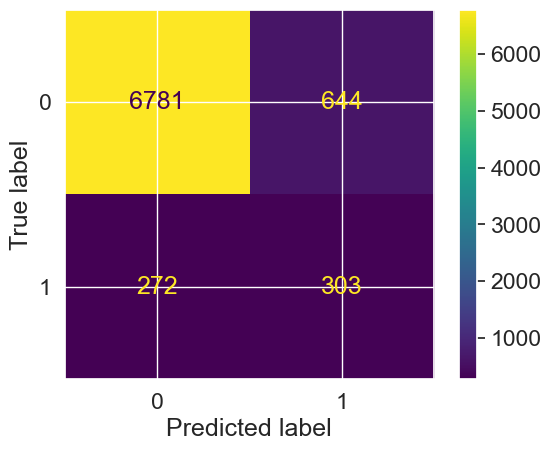

In [28]:
plot_confusion_matrix(dict_models['DecisionTreeClassifier'], X_test, Y_test)  
plt.show()

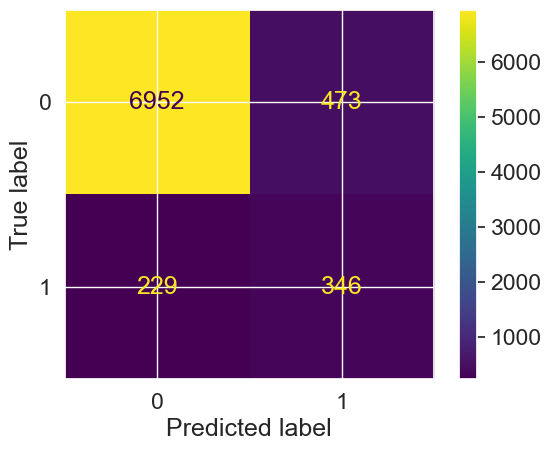

In [29]:
plot_confusion_matrix(dict_models['RandomForestClassifier'], X_test, Y_test)  
plt.show()

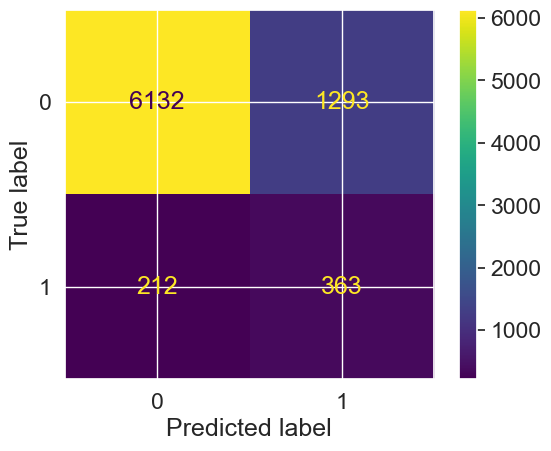

In [30]:
plot_confusion_matrix(dict_models['KNeighborsClassifier'], X_test, Y_test)  
plt.show()

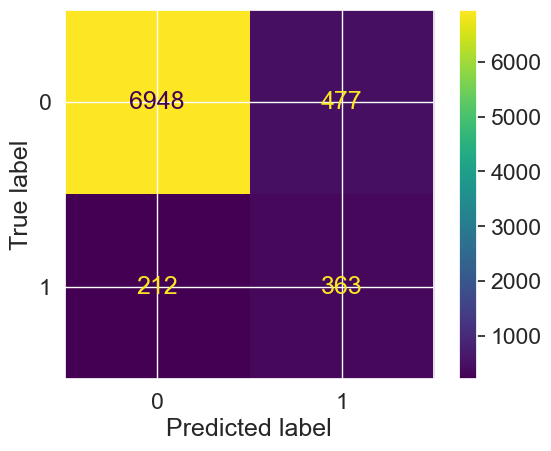

In [31]:
plot_confusion_matrix(dict_models['XGBClassifier'], X_test, Y_test)  
plt.show()

### Balancing the Dataset Using the Undersampling Technique, RandomUnderSampler

In [32]:
print("Before UnderSampling, counts of label '1': {}".format(sum(Y_train == 1)))
print("Before UnderSampling, counts of label '0': {} \n".format(sum(Y_train == 0)))

Usamp = RandomUnderSampler(random_state=0, sampling_strategy = 1.0)
x_train_res1, y_train_res1 = Usamp.fit_resample(X_train, Y_train)

print("After UnderSampling, counts of label '1': {}".format(sum(y_train_res1 == 1)))
print("After UnderSampling, counts of label '0': {}".format(sum(y_train_res1 == 0)))

Before UnderSampling, counts of label '1': 2321
Before UnderSampling, counts of label '0': 29679 

After UnderSampling, counts of label '1': 2321
After UnderSampling, counts of label '0': 2321


### Model Selection using the Undersampled Dataset

In [33]:
np.random.seed(0)
for model in list_models:
    modele =load_model(model)
    modele.fit(x_train_res1, y_train_res1)
    sc_train=modele.score(x_train_res1, y_train_res1)
    sc_test=modele.score(X_test,Y_test)
    dict_models[model]=modele
       
    print("score of on training ",model,"is :",sc_train,)
    Y_pred = dict_models[model].predict(X_test)
    print("\n report of the model: ", model,"\n", classification_report(Y_test, Y_pred),"\n")

score of on training  DecisionTreeClassifier is : 1.0

 report of the model:  DecisionTreeClassifier 
               precision    recall  f1-score   support

           0       0.99      0.84      0.91      7425
           1       0.29      0.84      0.43       575

    accuracy                           0.84      8000
   macro avg       0.64      0.84      0.67      8000
weighted avg       0.94      0.84      0.87      8000
 

score of on training  RandomForestClassifier is : 1.0

 report of the model:  RandomForestClassifier 
               precision    recall  f1-score   support

           0       0.99      0.86      0.92      7425
           1       0.33      0.90      0.48       575

    accuracy                           0.86      8000
   macro avg       0.66      0.88      0.70      8000
weighted avg       0.94      0.86      0.89      8000
 

score of on training  KNeighborsClassifier is : 0.8367083153813012

 report of the model:  KNeighborsClassifier 
               precisio

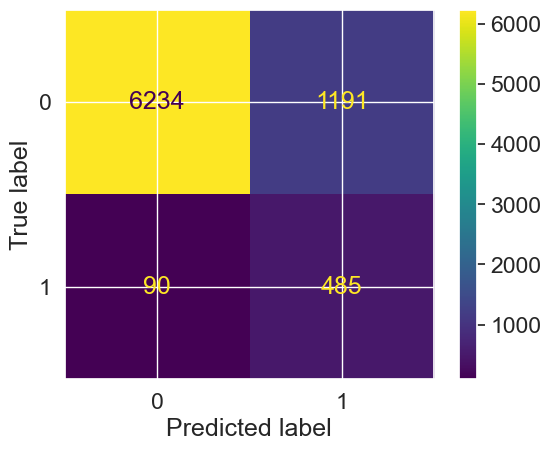

In [34]:
plot_confusion_matrix(dict_models['DecisionTreeClassifier'], X_test, Y_test)  
plt.show()

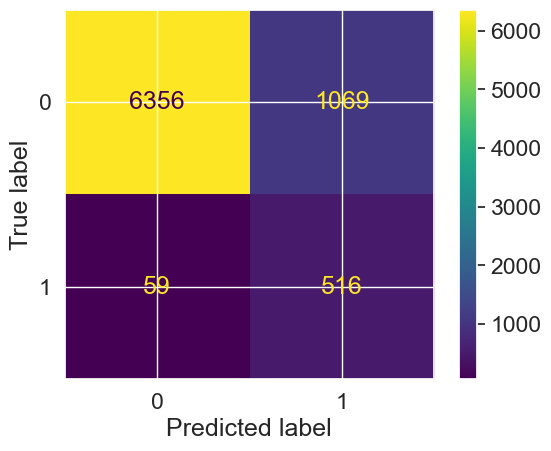

In [35]:
plot_confusion_matrix(dict_models['RandomForestClassifier'], X_test, Y_test)  
plt.show()

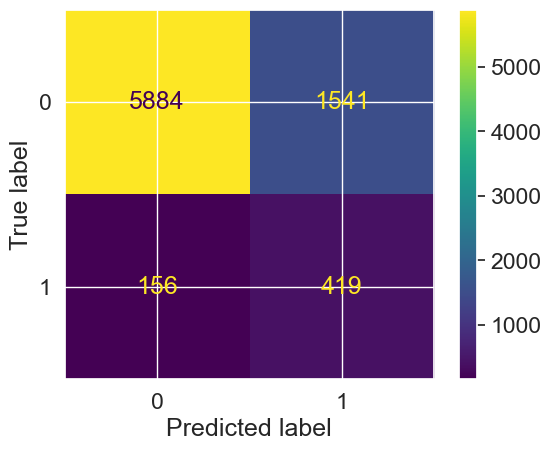

In [36]:
plot_confusion_matrix(dict_models['KNeighborsClassifier'], X_test, Y_test)  
plt.show()

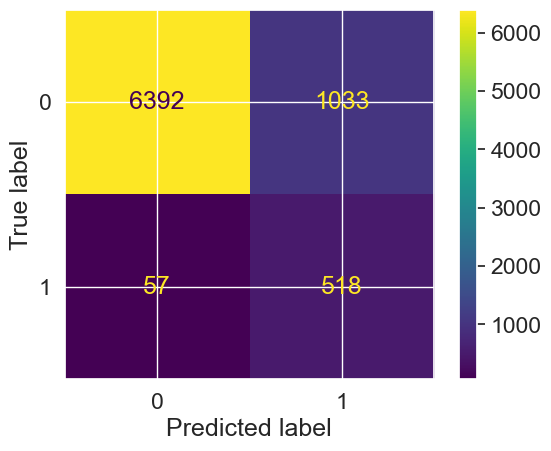

In [37]:
plot_confusion_matrix(dict_models['XGBClassifier'], X_test, Y_test)  
plt.show()

### Precision/Recall Trade-off (Introducting the threshold error metric)

Having balanced the Dataset by Oversampling and Undersampling we can see that our predictions are still highly skewed. In this case we will look into the objectives closely and decide on the classification metric to trade-off.

The key metrics used to evaluate the performance of machine learning classification models are **"Precision and recall"**. However, the trade-off between the two depends on the business prerogative and is best resolved through the PR curve. Analysing this curve we can balance precision and recall by choosing the right threshold to meet the business objective.

From the problem statement we understand that the ultimately goal is to fine ways to improve the success rate for calls made to customers for 'term deposit' which will be addressed iin the later session(feature selection). However, targeting the campaign to those without 'term deposit' would be a useful initial step to maintain a low **"False Positives"**, so the campaign can have a wider converage on customers without a "term deposit", thereby maintaining a relatively low precision. When predicting a "True class (y=1)", would be only when we are sure. This means we would be balancing precision and recall score using the optimal threshold from the curve below.

### Preditions on Original Dataset

In [38]:
np.random.seed(0)
for model in list_models:
    modele =load_model(model)
    modele.fit(X_train, Y_train)
    sc_train=modele.score(X_train, Y_train)
    sc_test=modele.score(X_test,Y_test)
    dict_models[model]=modele
       
    print("score of on training ",model,"is :",sc_train,)
    Y_pred = dict_models[model].predict(X_test)
    print("\n report of the model: ", model,"\n", classification_report(Y_test, Y_pred),"\n")

score of on training  DecisionTreeClassifier is : 1.0

 report of the model:  DecisionTreeClassifier 
               precision    recall  f1-score   support

           0       0.96      0.95      0.95      7425
           1       0.40      0.43      0.42       575

    accuracy                           0.91      8000
   macro avg       0.68      0.69      0.69      8000
weighted avg       0.92      0.91      0.91      8000
 

score of on training  RandomForestClassifier is : 1.0

 report of the model:  RandomForestClassifier 
               precision    recall  f1-score   support

           0       0.95      0.98      0.97      7425
           1       0.61      0.32      0.42       575

    accuracy                           0.94      8000
   macro avg       0.78      0.65      0.69      8000
weighted avg       0.93      0.94      0.93      8000
 

score of on training  KNeighborsClassifier is : 0.9416875

 report of the model:  KNeighborsClassifier 
               precision    reca

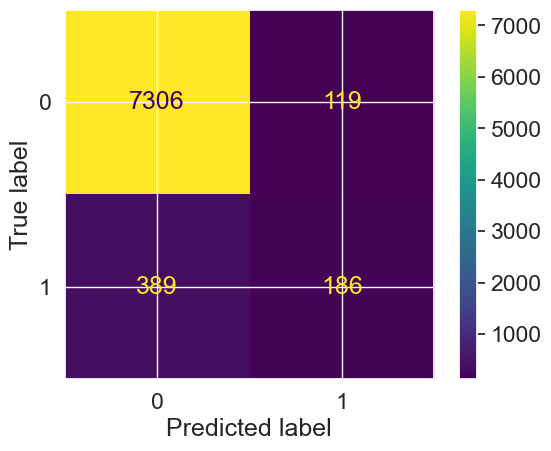

In [39]:
plot_confusion_matrix(dict_models['RandomForestClassifier'], X_test, Y_test)  
plt.show()

### Model Selection and Application of Threshold

The **random forest algorithm** seems to be performing better on the test set. Also it's a better algorithm as it is not affected by outliers (identified earlier)
* Here an optimal threshold would be applied on the original dataset

In [40]:
RF = RandomForestClassifier()
RF.fit(X_train, Y_train)

RandomForestClassifier()

In [41]:
# Predict probability
y_prob_train = RF.predict_proba(X_train)[:,1]
y_prob_test = RF.predict_proba(X_test)[:,1]
                                                  

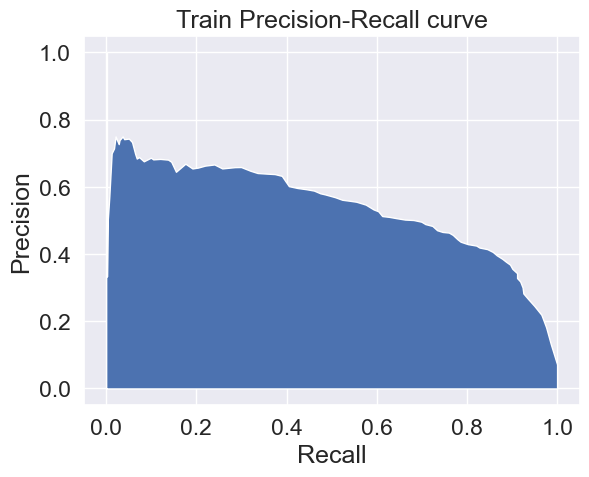

In [42]:
precision, recall, thresholds = precision_recall_curve(Y_test, y_prob_test)
plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Train Precision-Recall curve");

In [43]:
np.random.seed(0)
threshold = 0.5

sc_train_2=RF.score(X_train,Y_train)
y_prob_test = RF.predict_proba(X_test)[:,1]
Y_pred = (y_prob_test >= threshold) 

print("score of on training ",RF,"is :",sc_train_2,)
print("\n report of the model: ", RF,"\n", classification_report(Y_test, Y_pred),"\n")

score of on training  RandomForestClassifier() is : 1.0

 report of the model:  RandomForestClassifier() 
               precision    recall  f1-score   support

           0       0.95      0.98      0.97      7425
           1       0.64      0.37      0.47       575

    accuracy                           0.94      8000
   macro avg       0.80      0.68      0.72      8000
weighted avg       0.93      0.94      0.93      8000
 



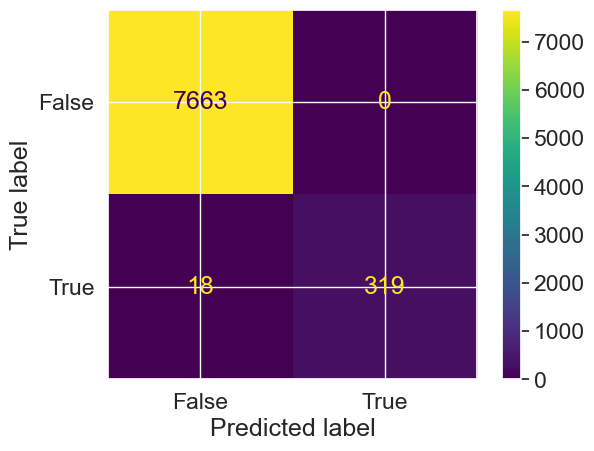

In [44]:
plot_confusion_matrix(RF, X_test, Y_pred)  
plt.show()

### Final Decision
After reviewing the results above, the Random forest algorithm performed best for this project. This algorithm with the threshold metric did a good job it's classification, perfectly detecting 'customers without a term deposit'. Hence, it would be saved as the base model.


### Feature Importance

In [45]:
# selecting the most important features from the base model

np.random.seed(0)
selector=SelectFromModel(RF)
selector.fit_transform(X_train,Y_train)
selector.get_support()
selected_feat=X.columns[(selector.get_support())]
selected_feat

Index(['age', 'balance', 'day', 'duration'], dtype='object')

### Conclusion:
The ultimate goal of this project is to find ways to improve the success rate for calls made to customers.
Hence, the need to look into the important features of the customers who subscribed (to a term deposit). This will give a better understanding of clients who have higher potentials/more likely to subcribe to a term deposit. 

In [47]:
#choose positive labels
pos_customers=Data[Data['y']=='yes']

In [48]:
pos_customers

age         job   marital  education default  balance housing loan  \
83      59       admin   married  secondary      no     2343     yes   no   
86      56       admin   married  secondary      no       45      no   no   
87      41  technician   married  secondary      no     1270     yes   no   
129     55    services   married  secondary      no     2476     yes   no   
168     54       admin   married   tertiary      no      184      no   no   
...    ...         ...       ...        ...     ...      ...     ...  ...   
39986   29  management    single   tertiary      no      637     yes   no   
39988   55  management  divorced   tertiary      no     2383      no   no   
39990   26  technician    single  secondary      no     1231     yes   no   
39996   30  management    single   tertiary      no     3340      no   no   
39997   54       admin  divorced  secondary      no      200      no   no   

        contact  day month  duration  campaign    y  
83      unknown    5   may      1042         1  yes  
86      unknown    5   may      1467         1  yes  
87      unknown    5   may      1389         1  yes  
129     unknown    5   may       579         1  yes  
168     unknown    5   may       673         2  yes  
...         ...  ...   ...       ...       ...  ...  
39986  cellular    3   jun       340         1  yes  
39988  cellular    3   jun       591         2  yes  
39990  cellular    3   jun       385         2  yes  
39996  cellular    3   jun       238         3  yes  
39997  cellular    3   jun       170         1  yes  

[2896 rows x 14 columns]

The 'age' column would be cut into bins to denote age groups and the average of both 'duration' and 'balance' would be taken to form our summary table

In [49]:
pos_customers['age_bins'] = pd.cut(pos_customers['age'], bins=4, labels=('young', 'middle_age', 'Seniors', 'old'))

In [50]:
pos_customers.head()

age         job  marital  education default  balance housing loan  \
83    59       admin  married  secondary      no     2343     yes   no   
86    56       admin  married  secondary      no       45      no   no   
87    41  technician  married  secondary      no     1270     yes   no   
129   55    services  married  secondary      no     2476     yes   no   
168   54       admin  married   tertiary      no      184      no   no   

     contact  day month  duration  campaign    y    age_bins  
83   unknown    5   may      1042         1  yes     Seniors  
86   unknown    5   may      1467         1  yes  middle_age  
87   unknown    5   may      1389         1  yes  middle_age  
129  unknown    5   may       579         1  yes  middle_age  
168  unknown    5   may       673         2  yes  middle_age

In [51]:
chart = pos_customers.groupby(['age_bins'], as_index=False).agg({'balance':'mean','duration':'mean', 'age':'count'})
chart

age_bins  balance  duration   age
0       young  1434.49    666.78  1549
1  middle_age  1656.60    728.19  1119
2     Seniors  2175.24    589.92   215
3         old  4372.77    256.31    13

In [52]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=chart['age_bins'],
        y=chart['age'],
        name="Number of Subscribers",


    ))

fig.add_trace(
    go.Scatter(
        x=chart['age_bins'],
        y=chart['balance'],
        name="Average Balance (in euros)",

    ))

fig.add_trace(
    go.Bar(
        x=chart['age_bins'],
        y=chart['duration'],
        name="Average Duration (in seconds)",
        text = chart['duration'],
        textposition='outside',
        textfont=dict(
        size=13,
        color='#1f77b4')

    ))
fig.update_traces(texttemplate='%{text:.2s}')
fig.update_layout(legend_title_text='Key',
                 title_text='Summary of Customers who Subscribed')
fig.show()

The summary above shows the likelihood of a customer subscribing to a term deposit decreases as the age increases; even with a low balance the young and middle age groups subscribed more.